dict {'startTime': 0, 'startPosition': 0.6}
dict {'startTime': 0, 'startPosition': 0.6}


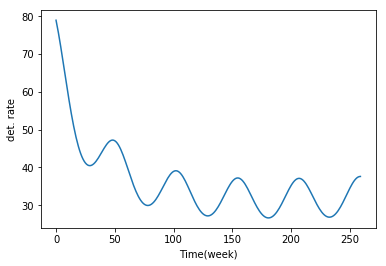

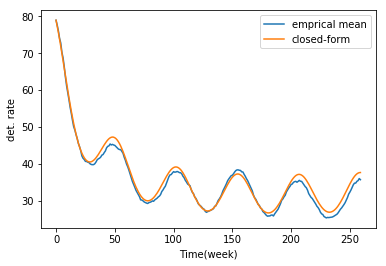

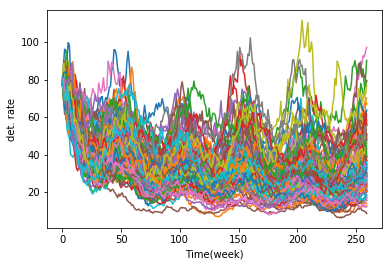

In [3]:
# -*- coding: utf-8 -*-
"""
Spyder Danial Mohseni Taheri

"""
import numpy as np
import matplotlib.pyplot as plt
import inputProcessing
import pandas as pd
import json
import math
import GammaProcess


class generate_Sample_Avr:
    def __init__(self):
        self.config = self.read_parameters_form_json()
        self.KX = self.config['KX']
        self.muY = self.config['muY']
        self.lambdaX = self.config['lambdaX']
        self.sigmaX = self.config["sigmaX"]
        self.sigmaY = self.config["sigmaY"]
        self.rhoXY = self.config["rhoXY"]
        self.dt = self.config['dt']
        self.beta = self.config['beta']
        self.alpha = self.config['alpha']
        self.InflowMeans = self.config["inflow_log_mean"]
        self.InflowSd = self.config["inflow_log_sd"]
        self.KInflow = self.config["KInflow"]
        self.sigmaInflow = self.config["sigmaInflow"]
        self.parameters = {'shape_param': self.config["shape_param"], 'rate_param':\
                  self.config["rate_param"]}
        
        
    def read_parameters_form_json(self):
        with open('Parameters.json') as f:
            config = json.load(f)
        return config
        
    def generate_Sample(self, initial_condition):
        T = self.config['nPeriods'] * self.config['dt']
        self.Inflow0 = initial_condition['Inflow0']
        self.X0 = initial_condition['X0']
        self.Y0 = initial_condition['Y0']
        
        def generate_loginf_logprice(T):
            I = self.config['nPeriods']
            dwX = np.random.normal(0, 1, I)
            dwY = np.random.normal(0, 1, I)
            dwInflow = np.random.normal(0, np.sqrt((1-np.exp(-2 * self.KInflow * self.dt))/\
                                             (2*self.KInflow)), I)
            Sigma = [(1-math.exp(-2*self.KX * self.dt))/(2*self.KX)*\
                     self.sigmaX**2, self.rhoXY*self.sigmaX*\
                     self.sigmaY*(1-math.exp(-self.KX*self.dt))/\
                     self.KX, self.rhoXY*self.sigmaX*\
                     self.sigmaY *(1-math.exp(-self.KX * self.dt))/\
                     self.KX, self.sigmaY**2*self.dt]

            Sigma = np.asarray(Sigma).reshape(2,2)
            S_chol = np.transpose(np.linalg.cholesky(Sigma))
            x = np.ones(I)* self.X0
            y = np.ones(I)* self.Y0
            Inflow = np.ones(I)* self.Inflow0
            for i in range(1, I):
                x[i] = x[i-1]* math.exp(-self.KX * self.dt)-\
                self.lambdaX*(1 - math.exp(-self.KX*self.dt))+\
                S_chol[0,0]*dwX[i-1]
                                        
                y[i] = y[i-1] + self.muY*self.dt + S_chol[1,0]*dwX[i-1]+\
                S_chol[1,1]*dwY[i-1]
                Inflow[i] = Inflow[i-1] * math.exp(-self.KInflow * self.dt)+\
                self.sigmaInflow * dwInflow[i-1]
            return x, y, Inflow
                                        
                                        
                                              

                                              
        K = self.config["n_Samples"]
        I = self.config["nPeriods"]

        #Store inflow (I) and price (P) on original scale
        w = np.zeros((I, K, 6))
        start_time_position = {"startTime": self.config["Gamma_startTime"], "startPosition":\
                               self.config["plant_cond0"]}
        Gamma = GammaProcess.Gamma_process(self.parameters, start_time_position)
        for k in range(K):
            x, y, Inflow = generate_loginf_logprice(T)
                                              
            for i in range(I):
                w[i, k, 0] = np.exp(self.alpha * np.cos(2*np.pi * i * self.dt)+\
                                    self.beta * np.sin(2* np.pi * i * self.dt))
                w[i, k, 1] = np.exp(x[i])
                w[i, k, 2] = np.exp(y[i])
                w[i, k, 3] = np.exp(self.config["inflow_log_mean"][i%52]) 
                w[i, k, 4] = np.exp(Inflow[i]* self.config["inflow_log_sd"][i%52])
                
            w[:, k, 5] = np.array(Gamma._generate_sample_path(range(I)))
                      
        return w
    
    def generate_Average(self, I, K, initial_condition):
        E_w = np.zeros((I, K, 6))
        time_space_constraints= {"startTime": initial_condition['Start_time'], "startPosition": initial_condition['Gamma0']}
        Gamma = GammaProcess.Gamma_process(self.parameters, time_space_constraints)
        Y0 = initial_condition['Y0'] 
        X0 = initial_condition['X0']
        Inflow0 = initial_condition['Inflow0']
        T_0 = initial_condition['Start_time']
        for i in range(I):
            price_longtermMean = Y0 + self.muY * i* self.dt
            price_shorttermMean = math.exp(-self.KX * i* self.dt)* X0 - \
                                        ((1-math.exp(-self.KX * i* self.dt))* self.lambdaX/self.KX)
            price_variance = (1-math.exp(-2 * self.KX * i* self.dt))*self.sigmaX**2/(2*self.KX) +\
            self.sigmaY**2 * i * self.dt  + 2* (1-math.exp(-(self.KX)* i * self.dt)) *\
            (self.sigmaX * self.sigmaY * self.rhoXY/(self.KX))
                                     
            price_constant = self.alpha * np.cos(2*np.pi * ((i+T_0) * self.dt))+\
            self.beta * np.sin(2* np.pi*((i+T_0) * self.dt))   
            
            Inflow_constant = self.InflowMeans[(i+T_0)%52]
            Inflow_Mean =  self.InflowSd[(i+T_0)%52] * math.exp(-self.KInflow * i * self.dt)*\
            Inflow0
            Inflow_Var = self.InflowSd[(i+T_0)%52]**2 * (1-math.exp(-2*self.KInflow*i* self.dt))*\
            self.sigmaInflow**2/(2*self.KInflow)


            for k in range(K):
                E_w[i, k, 0] = np.exp(price_constant + 0.5 * price_variance)
                E_w[i, k, 1] = np.exp(price_shorttermMean)
                E_w[i, k, 2] = np.exp(price_longtermMean)
                E_w[i, k, 3] = np.exp(Inflow_constant +  (1/2) * Inflow_Var)
                E_w[i, k, 4] = np.exp(Inflow_Mean)
                E_w[i, k, 5] = Gamma._get_mean_at(i)

        return E_w

def read_parameters_form_json():
    with open('Parameters.json') as f:
        config = json.load(f)
    return config

if __name__ == '__main__':
    config = read_parameters_form_json()
    #Inflow plot
    initial_condition = {'X0': config['X0'], 'Y0': config['Y0'],\
                    'Inflow0': config['Inflow0'], 'Start_time': 0, 'Gamma0': config['plant_cond0']}
    Sample = generate_Sample_Avr()
    K = config["n_Samples"]
    I = config["nPeriods"]
    w = Sample.generate_Sample(initial_condition)
    E_w = Sample.generate_Average(I, K, initial_condition)
    
    plt.figure()
    plt.plot(range(config['nPeriods']), np.multiply(np.multiply(E_w[:, 1, 0], E_w[:, 1, 1]), E_w[:, 1, 2]) )
    #plt.plot(range(n), meanI.transpose())
    plt.xlabel("Time(week)")
    plt.ylabel("det. rate")
    plt.show()




    #Price plot
    plt.figure()
    plt.plot(range(config['nPeriods']), np.mean(np.multiply(np.multiply(w[:, :, 0], w[:, :, 1]), w[:, :, 2]), axis = 1), label = "emprical mean")
    plt.plot(range(config['nPeriods']), np.multiply(np.multiply(E_w[:, 1, 0], E_w[:, 1, 1]), E_w[:, 1, 2]), label = "closed-form")
    plt.xlabel("Time(week)")
    plt.ylabel("det. rate")
    plt.legend()
    plt.show()
    #Price plot
    plt.figure()
    plt.plot(range(config['nPeriods']), np.multiply(np.multiply(w[:, :, 0], w[:, :, 1]), w[:, :, 2]))

    plt.xlabel("Time(week)")
    plt.ylabel("det. rate")
    plt.show()

In [28]:
def read_table(file_name):
    with open(file_name) as json_file:
        table = json.load(json_file)
    return table
table = read_table('Table.json')
Month = '0'
features = {}
feature1 = []
feature2 = []
value = []
for elem in table[Month]:
    features[(elem[0], elem[1]/100.)] = elem[2]
    feature1.append(elem[0])
    feature2.append(elem[1]/100.)
    value.append([elem[2]])
n_feature1 = sorted(set(feature1))
n_feature2 = sorted(set(feature2))

Terminal_value = np.zeros((len(n_feature1), len(n_feature2)))
for i, f1 in enumerate(n_feature1):
    for j, f2 in enumerate(n_feature2):
        Terminal_value[i][j] = features[(f1, f2)]

In [29]:
Terminal_value

array([[ 775.85286795,  721.46990633,  663.5120524 ,  599.50538343,
         530.56805604,  458.90905058,  385.06984224,  309.4370474 ,
         231.62803971,  126.51814875,    0.        ],
       [ 778.31333266,  723.86760741,  665.84727605,  601.53088564,
         532.44331089,  460.70679458,  386.79065554,  311.10962127,
         233.23887373,  127.06282346,    0.        ],
       [ 780.6719655 ,  726.07732797,  667.95545681,  603.55841915,
         534.27436563,  462.44172574,  388.43070719,  312.6847671 ,
         234.73175072,  127.60366739,    0.        ],
       [ 783.03182684,  728.2482818 ,  669.98238056,  605.36048425,
         535.99495653,  464.12039638,  390.07206771,  314.27302201,
         236.20955681,  127.91295683,    0.        ],
       [ 785.37761797,  730.5439484 ,  672.22556192,  607.29941622,
         537.79403198,  465.84927523,  391.72765607,  315.88456235,
         237.76019054,  128.40106628,    0.        ],
       [ 787.59946084,  732.62987892,  674.2170834

In [30]:
features


{(1, 0.0): 775.8528679456298,
 (1, 0.1): 721.4699063255996,
 (1, 0.2): 663.512052404861,
 (1, 0.3): 599.5053834332614,
 (1, 0.4): 530.5680560372889,
 (1, 0.5): 458.90905057945577,
 (1, 0.6): 385.06984224236345,
 (1, 0.7): 309.43704740207494,
 (1, 0.8): 231.62803970892384,
 (1, 0.9): 126.51814874909748,
 (1, 1.0): 0.0,
 (2, 0.0): 778.3133326559558,
 (2, 0.1): 723.8676074126151,
 (2, 0.2): 665.8472760456643,
 (2, 0.3): 601.5308856440731,
 (2, 0.4): 532.4433108905216,
 (2, 0.5): 460.70679458497204,
 (2, 0.6): 386.7906555426036,
 (2, 0.7): 311.10962127242965,
 (2, 0.8): 233.23887372948516,
 (2, 0.9): 127.0628234641953,
 (2, 1.0): 0.0,
 (3, 0.0): 780.6719654972916,
 (3, 0.1): 726.0773279745215,
 (3, 0.2): 667.955456808341,
 (3, 0.3): 603.558419148867,
 (3, 0.4): 534.2743656338359,
 (3, 0.5): 462.44172573944604,
 (3, 0.6): 388.43070718686187,
 (3, 0.7): 312.68476709626566,
 (3, 0.8): 234.73175071991326,
 (3, 0.9): 127.60366738852284,
 (3, 1.0): 0.0,
 (4, 0.0): 783.031826844685,
 (4, 0.1): 72